# Time-Decaying Gaussian Process UCB Algorithms
## Minimal Verifying Problem

See ideas at https://www.dropbox.com/s/krqreih872ionmo/%5BIdea%5D%20GP-t%20Algorithm.pdf?dl=0

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    print v

# World

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


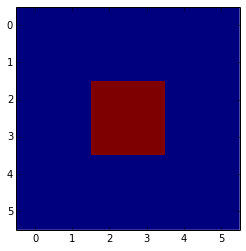

In [8]:
# world 2
H = W = 6
grid = np.zeros((H, W))
grid[2:4, 2:4] = 1.
showV(grid)

## The goals are correlated

In [9]:
all_tasks = generate_gridworlds(grid)
# random.shuffle(all_tasks)
tasks = all_tasks[:2] + all_tasks[-2:]

In [10]:
for task in tasks:
    print task.goal

{(0, 0): 1.0}
{(0, 1): 1.0}
{(5, 4): 1.0}
{(5, 5): 1.0}


# Network Architecture

In [11]:
# neural network architecture.
# shared weights between state and goal due to symmetry.
def two_stream_arch(states, input_dim=H * W, output_dim=4):
    params = []
    ## agent.
    H_AGENT_DIM1 = 8
    fc_agent1 = layers.FullyConnected(input_dim, H_AGENT_DIM1, activation='relu')
    h_agent1 = fc_agent1(states[:, :input_dim])
    h_goal1 = fc_agent1(states[:, input_dim:2*input_dim]) # shared weights.
    ## combine them all!
    v_joint = T.concatenate([h_agent1, h_goal1], axis=1)
    H_JOINT_DIM = 32
    fc_joint = layers.FullyConnected(2 * H_AGENT_DIM1, H_JOINT_DIM, activation='relu')
    linear_layer = layers.FullyConnected(H_JOINT_DIM, output_dim, activation=None)
    
    output = linear_layer(fc_joint(v_joint))
    
    model = {
        'fc_agent1': fc_agent1,
        'fc_joint': fc_joint,
        'linear_layer': linear_layer
    }
    return (output, model)



### distance metric.

In [12]:
def dist(task1, task2):
    pos1 = task1.goal.keys()[0]
    pos2 = task2.goal.keys()[0]
    return np.abs(pos1[0] - pos2[0])+ np.abs(pos1[1] - pos2[1])

In [13]:
dist(tasks[0], tasks[3])

10

In [14]:
gpt_v=1e-2
gpt_r = 1. / (H + W)
gpt_sigma = 1e-1
gpt_eta = 1e-2
cov_func = lambda task1, task2, t1, t2: gpt_v * np.exp(- (dist(task1, task2) ** 2 * gpt_r + gpt_eta * (t1 - t2) ** 2))
cov_func(tasks[0], tasks[1], 0, 1)

0.0091088981974561216

## Gaussian Process Adaptive Curriculum

[chosen task]  1
mu None
sigma None
ucb None
performance 0.148056360208 progress 0.0362821395073
task rewards [ 0.22675909  0.23291515  0.05724818  0.07530303]
[chosen task]  1
mu [  1.65245158e-02   1.79605631e-02   8.67127005e-05   2.10296573e-05]
sigma [ 0.0158514   0.01509901  0.01999989  0.01999999]
ucb [ 0.02445022  0.02551007  0.01008666  0.01002103]
performance 0.163102670886 progress 0.0150463106787
task rewards [ 0.27619977  0.24512655  0.05457978  0.07650457]
[chosen task]  1
mu [  1.51226222e-02   1.64368393e-02   7.93562384e-05   1.92455602e-05]
sigma [ 0.01460935  0.0136317   0.01999985  0.01999999]
ucb [ 0.0224273   0.02325269  0.01007928  0.01001924]
performance 0.188485974623 progress 0.0253833037367
task rewards [ 0.32475359  0.31794496  0.05014858  0.06109677]
[chosen task]  1
mu [  1.66325230e-02   1.80779566e-02   8.72794704e-05   2.11671110e-05]
sigma [ 0.01412962  0.01306496  0.01999984  0.01999999]
ucb [ 0.02369733  0.02461044  0.0100872   0.01002116]
performanc

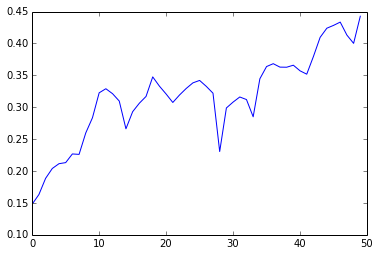

In [29]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerGPt(dqn, tasks, dist=dist, 
                           gpt_eta=1e-2, gpt_r=1. / (H + W), gpt_v=1e-2, gpt_sigma=1e-1, gpt_kappa=0.5,
                           lr=1e-4, memory_size=250)


performances = []
for it in range(50):
    learner.run(num_epochs=1, num_episodes=10)
    print '[chosen task] ', learner.last_task_ti
    print 'mu', learner.mu
    print 'sigma', learner.sigma
    print 'ucb', learner.ucb
    print 'performance', learner.last_performance, 'progress', learner.last_progress
    print 'task rewards', learner.last_task_performance
    performances.append(learner.last_performance)
plot(performances)

[chosen task]  1
mu None
sigma None
ucb None
performance 0.139689943947 progress -0.0322083881021
task rewards [ 0.07060922  0.2021733   0.10266361  0.18331365]
[chosen task]  3
mu [ -1.34065904e-02  -1.45716774e-02  -7.03513296e-05  -1.70616801e-05]
sigma [ 0.0165348   0.01590635  0.0199999   0.01999999]
ucb [-0.00513919 -0.0066185   0.0099296   0.00998294]
performance 0.134710377379 progress -0.00497956656765
task rewards [ 0.14561629  0.15363673  0.10772587  0.13186261]
[chosen task]  2
mu [-0.00993158 -0.01079671 -0.00211773 -0.00225777]
sigma [ 0.01809826  0.01775335  0.01653476  0.01590635]
ucb [-0.00088245 -0.00192004  0.00614965  0.0056954 ]
performance 0.10346658352 progress -0.0312437938587
task rewards [ 0.09165127  0.07753373  0.13771085  0.10697048]
[chosen task]  0
mu [-0.00603215 -0.00661008 -0.01297864 -0.01142035]
sigma [ 0.01930039  0.01917343  0.01555773  0.0159007 ]
ucb [ 0.00361804  0.00297664 -0.00519978 -0.00347   ]
performance 0.120154654035 progress 0.016688070

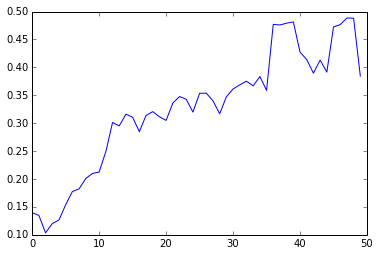

In [28]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerGPt(dqn, tasks, dist=dist, 
                           gpt_eta=1e-1, gpt_r=1. / (H + W), gpt_v=1e-2, gpt_sigma=1e-1, gpt_kappa=0.5,
                           lr=1e-4, memory_size=250)


performances = []
for it in range(50):
    learner.run(num_epochs=1, num_episodes=10)
    print '[chosen task] ', learner.last_task_ti
    print 'mu', learner.mu
    print 'sigma', learner.sigma
    print 'ucb', learner.ucb
    print 'performance', learner.last_performance, 'progress', learner.last_progress
    print 'task rewards', learner.last_task_performance
    performances.append(learner.last_performance)
plot(performances)

## Sequential Learners

it 0 train_performances 0.108238645911
task id 1 rewards [ 0.202573    0.0296032   0.09624655  0.10453183]
it 1 train_performances 0.110988483302
task id 2 rewards [ 0.14626229  0.13877892  0.05698534  0.10192739]
it 2 train_performances 0.147814466653
task id 3 rewards [ 0.05726567  0.06358754  0.27114009  0.19926457]
it 3 train_performances 0.186485666854
task id 0 rewards [ 0.04593389  0.05181301  0.30821954  0.33997624]
it 4 train_performances 0.226860367164
task id 1 rewards [ 0.3877079   0.14801622  0.1902104   0.18150695]
it 5 train_performances 0.244654590826
task id 2 rewards [ 0.45568629  0.28768769  0.12959893  0.10564545]
it 6 train_performances 0.252207007276
task id 3 rewards [ 0.30874092  0.22317951  0.25122951  0.22567809]
it 7 train_performances 0.261892867846
task id 0 rewards [ 0.30344538  0.19592885  0.24168143  0.30651581]
it 8 train_performances 0.307097206491
task id 1 rewards [ 0.50915551  0.32460942  0.15894629  0.23567761]
it 9 train_performances 0.35852129185

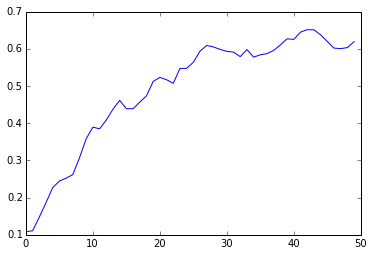

In [279]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerSequential(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(50):
    learner.run(num_epochs = 1, num_episodes = 10)
    last_task_performance = np.zeros(len(tasks))
    for ti in range(len(tasks)):
        last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks[ti], tol=1e-4)
    train_performances.append(np.mean(last_task_performance))
    print 'it', it, 'train_performances', train_performances[-1]
    print 'task id', learner.t % len(tasks), 'rewards', last_task_performance
plot(train_performances)


In [ ]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerSequential(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 50)
    train_performances.append(eval_dataset(dqn, tasks))
    print 'it', it, 'train_performances', train_performances[-1]
plot(train_performances)



## Greedy Learner

 it 0 train_performances 0.17258547884
task id 3 rewards [ 0.03786426  0.43693906  0.08890913  0.12662946]
it 1 train_performances 0.198910233078
task id 0 rewards [ 0.17592861  0.43428746  0.08934592  0.09607895]
it 2 train_performances 0.20607906562
task id 2 rewards [ 0.12431314  0.39890943  0.18717791  0.11391578]
it 3 train_performances 0.200833097872
task id 3 rewards [ 0.12555379  0.36691895  0.1569038   0.15395585]
it 4 train_performances 0.252589025708
task id 0 rewards [ 0.23598068  0.41862761  0.18594897  0.16979884]
it 5 train_performances 0.266463083937
task id 3 rewards [ 0.20667993  0.4469089   0.15826409  0.25399941]
it 6 train_performances 0.303226928686
task id 2 rewards [ 0.09592234  0.43914599  0.32557333  0.35226606]
it 7 train_performances 0.326231279047
task id 0 rewards [ 0.4628027   0.501686    0.17528968  0.16514673]
it 8 train_performances 0.327220594462
task id 3 rewards [ 0.51155832  0.47002521  0.11430536  0.21299349]
it 9 train_performances 0.315988978573

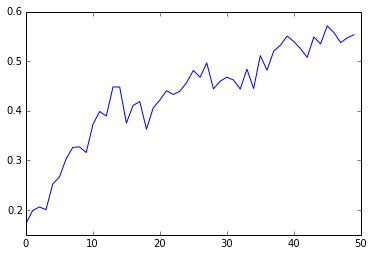

In [284]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerCommunist(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(50):
    learner.run(num_epochs = 1, num_episodes = 10)
    last_task_performance = np.zeros(len(tasks))
    for ti in range(len(tasks)):
        last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks[ti], tol=1e-4)
    train_performances.append(np.mean(last_task_performance))
    print 'it', it, 'train_performances', train_performances[-1]
    print 'task id', learner.last_task_ti, 'rewards', last_task_performance
plot(train_performances)



## Random Learner

 it 0 train_performances 0.114370623388
task id 0 rewards [ 0.12680233  0.16319892  0.13170179  0.03577945]
it 1 train_performances 0.155526157586
task id 1 rewards [ 0.15217943  0.14140075  0.17051299  0.15801146]
it 2 train_performances 0.211271754277
task id 3 rewards [ 0.09088676  0.06640469  0.21514102  0.47265454]
it 3 train_performances 0.216347686192
task id 0 rewards [ 0.16363304  0.09903726  0.21107993  0.39164051]
it 4 train_performances 0.258690036375
task id 3 rewards [ 0.09895377  0.06240597  0.30713605  0.56626436]
it 5 train_performances 0.235825184736
task id 3 rewards [ 0.14882901  0.09104925  0.23718307  0.46623941]
it 6 train_performances 0.282396682046
task id 1 rewards [ 0.10221222  0.16621086  0.21874524  0.64241841]
it 7 train_performances 0.313387225927
task id 0 rewards [ 0.20074908  0.14623572  0.24239847  0.66416563]
it 8 train_performances 0.316778578914
task id 1 rewards [ 0.23021212  0.237537    0.15795243  0.64141277]
it 9 train_performances 0.2642921408

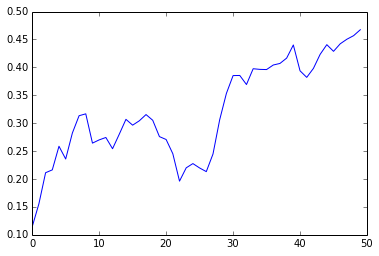

In [287]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerRandom(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(50):
    learner.run(num_epochs = 1, num_episodes = 10)
    last_task_performance = np.zeros(len(tasks))
    for ti in range(len(tasks)):
        last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks[ti], tol=1e-4)
    train_performances.append(np.mean(last_task_performance))
    print 'it', it, 'train_performances', train_performances[-1]
    print 'task id', learner.last_task_ti, 'rewards', last_task_performance
plot(train_performances)




## 1313

In [19]:
class SingleLearner1324(object):
    def __init__(self, dqn, tasks, **kwargs):
        self.dqn = dqn
        self.tasks = tasks
        self.num_tasks = len(self.tasks)
        self.deepQlearn = DeepQlearn(tasks[0], dqn, **kwargs)
        self.t = 0
        self.last_task_ti = 0

    def run(self, num_epochs=1, num_episodes=1):
        for ei in range(num_epochs):
            if self.t % 8 == 1:
                ti = 1
            elif self.t % 8 == 2:
                ti = 3
            elif self.t % 2 == 1:
                ti = 0
            else:
                ti = 2
            task = self.tasks[ti]

            # (TODO) this breaks away the abstraction.
            self.deepQlearn.task = task
            self.dqn.task = task
            # run training.
            self.deepQlearn.run(num_episodes, task)

            self.t += 1
            self.last_task_ti = ti

it 0 train_performances 0.161387148231
task id 2 rewards [ 0.02240888  0.08842563  0.26386415  0.27084993]
it 1 train_performances 0.139944928255
task id 1 rewards [ 0.11139547  0.21595845  0.14467405  0.08775174]
it 2 train_performances 0.201815877724
task id 3 rewards [ 0.06073318  0.19691164  0.23184576  0.31777293]
it 3 train_performances 0.239450065764
task id 0 rewards [ 0.20803862  0.15211752  0.24891233  0.3487318 ]
it 4 train_performances 0.229162035982
task id 2 rewards [ 0.25732513  0.16410851  0.17068412  0.32453038]
it 5 train_performances 0.274627853985
task id 0 rewards [ 0.29523897  0.14773246  0.2305061   0.42503389]
it 6 train_performances 0.282349440065
task id 2 rewards [ 0.39072846  0.14141556  0.17769515  0.41955859]
it 7 train_performances 0.303061139839
task id 0 rewards [ 0.35311007  0.14108881  0.21317654  0.50486914]
it 8 train_performances 0.325167166112
task id 2 rewards [ 0.38435493  0.12722861  0.24453159  0.54455353]
it 9 train_performances 0.29166419001

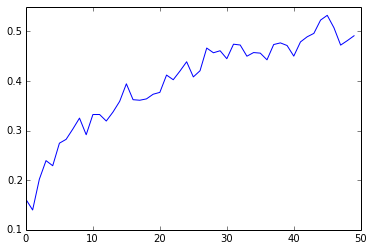

In [20]:
#dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearner1324(dqn, tasks, 
                           lr=1e-4, memory_size=250)
train_performances = []
for it in range(50):
    learner.run(num_epochs = 1, num_episodes = 10)
    last_task_performance = np.zeros(len(tasks))
    for ti in range(len(tasks)):
        last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks[ti], tol=1e-4)
    train_performances.append(np.mean(last_task_performance))
    print 'it', it, 'train_performances', train_performances[-1]
    print 'task id', learner.last_task_ti, 'rewards', last_task_performance
plot(train_performances)



